In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spooky-author-identification/train.zip
/kaggle/input/spooky-author-identification/test.zip
/kaggle/input/spooky-author-identification/sample_submission.zip


In [2]:
df = pd.read_csv('/kaggle/input/spooky-author-identification/train.zip')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
from sklearn.model_selection import train_test_split
X,y  = df["text"],df['author']
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

type(y_train)

list

In [4]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stopword = set(stopwords.words('english'))
import re
def preprocess(text):
    # remove punctuations 
    text = re.sub(r',|;|:|!|\.','',text)
    # tokenize text into words
    tokens = word_tokenize(text)
    # lowercase conversion
    tokens = [word.lower() for word in tokens]
    # stopwords removal
    filtered = [word for word in tokens if not word in stopword]
    "may need to preserve order of sentence"
    filtered = set(filtered)
    
    # Stemming
    ps = PorterStemmer()
    processed_text = [ps.stem(word) for word in filtered]
    return processed_text

preprocess("This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.")

['mean',
 'fact',
 'point',
 'awar',
 'uniform',
 'ascertain',
 'perfectli',
 'dimens',
 'whenc',
 'return',
 'process',
 'set',
 'without',
 'seem',
 'might',
 'circuit',
 'dungeon',
 'afford',
 'howev',
 'make',
 'wall']

In [5]:
l = []
vocab = []
d = {'EAP':0,'HPL':1,'MWS':2}
for text in X_train:
    x = preprocess(text)
    l.append(x)
    for word in x:
        if word not in vocab:
            vocab.append(word)
X_train = l
l = [d[i] for i in y_train]
y_train = l

In [6]:
len(vocab),len(set(vocab))

(13749, 13749)

In [7]:
# Making frequency dictionary
freqs = {}
def count_freqs(text,y,freqs=freqs):
    for word in text:
        pair = (word,y)
        if pair in freqs.keys():
            freqs[pair] += 1
        else:
            freqs[pair] = 1
    return freqs

for text,y in zip(X_train,y_train):
    freqs = count_freqs(text,y)

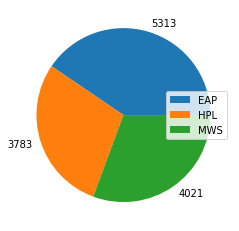

In [8]:
import matplotlib.pyplot as plt

y_train_class = [0,0,0]
for i in y_train:
    if i == 0:
        y_train_class[0] += 1
    elif i == 1:
        y_train_class[1] += 1
    else:
        y_train_class[2] += 1

# y_train_class
plt.pie(y_train_class,labels =y_train_class)
plt.legend(labels = d,loc = 'center right')
plt.show()

In [9]:
prob_y = [(count / len(y_train)) for count in y_train_class]
prob_y

[0.4050468857208203, 0.288404360753221, 0.3065487535259587]

In [10]:
# Finding probability of word given that it belongs to class 0,1,2 respectively
def count_word_probability(word,class_count = y_train_class,vocab = vocab):
    
    # Class 0 : EAP
    pair = (word,0)
    cnt = 0
    if pair in freqs.keys():
        cnt = freqs[pair]
    # Laplacian smoothing alpha = 1 ,k = len(vocab)
    prob0 = (cnt + 1) / (class_count[0] + len(vocab))
    
    # Class 1 : HPL
    pair = (word,1)
    cnt = 0
    if pair in freqs.keys():
        cnt = freqs[pair]
    # Laplacian smoothing alpha = 1 ,k = len(vocab)
    prob1 = (cnt + 1) / (class_count[1] + len(vocab))
    
    # Class 2 : MWS
    pair = (word,2)
    cnt = 0
    if pair in freqs.keys():
        cnt = freqs[pair]
    # Laplacian smoothing alpha = 1 ,k = len(vocab)
    prob2 = (cnt + 1) / (class_count[2] + len(vocab))
    
    return prob0,prob1,prob2


In [11]:
l_test = []
for text in X_val:
    l_test.append(preprocess(text))
X_val = l_test

In [12]:
X_val[0]

['dazzl',
 'avail',
 'topic',
 'immedi',
 'gigant',
 'natur',
 'sum',
 'thought',
 'bewild',
 'magnitud',
 'upon']

In [13]:
# Computing log likelihoods for numerical computation
from math import log
def predict_class(text,vocab = vocab):
    log_prob_class = [log(prob_y[0]),log(prob_y[1]),log(prob_y[2])]
    prob_class = [log(prob_y[0]),log(prob_y[1]),log(prob_y[2])]
    for word in text:
        prob_w = count_word_probability(word)
        log_prob_class = [(log_prob_class[i] + log(prob_w[i])) for i in range(3)]
        prob_class = [(prob_class[i] * (prob_w[i])) for i in range(3)]
    return log_prob_class.index(max(log_prob_class))
        

        

In [14]:
y_hat = []
inv_d = {0:'EAP',1:'HPL',2:'MWS'}
for text in X_val:
    y_hat.append(inv_d[predict_class(text)])
y_hat[0],y_val[0]
    

('EAP', 'EAP')

In [15]:
y_hat = np.array(y_hat)
y_val = np.array(y_val)
accuracy = np.sum(y_hat == y_val) / y_val.shape[0]
accuracy

0.8207985143918292

# Using NAIVE BAYE'S we get 82.07 % accuracy in the problem of author identfication